In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef




In [2]:
df = pd.read_csv('../Feature Engineering/EPL_Final_cleaned_features_v2.csv')
df.head(5)

,Temperature,Humidity,WindDirection,Precipitation,WindSpeed,Home_Prv_FTHG,Home_Prv_HS,Home_Prv_HST,Home_Prv_HF,Home_Prv_HC,...,WeatherCode_Clear,WeatherCode_Clouds,WeatherCode_Drizzle,WeatherCode_Fog,WeatherCode_Haze,WeatherCode_Mist,WeatherCode_Rain,WeatherCode_Snow,Time_of_Day_Afternoon,Time_of_Day_Evening
0,1.589044,-0.947690,0.173322,-0.362486,1.677221,0.561811,0.043716,-0.045927,-0.171534,0.002643,...,0,1,0,0,0,0,0,0,1,0
1,1.917548,-0.815443,0.500378,-0.362486,1.280300,1.363757,2.156421,1.555162,-0.443552,1.065042,...,1,0,0,0,0,0,0,0,1,0
2,1.400248,-0.418701,0.816532,-0.362486,0.273563,0.561811,-0.340412,-0.846471,-1.259605,-0.351490,...,0,1,0,0,0,0,0,0,1,0
3,1.811823,-0.683196,0.500378,-0.362486,0.558625,0.561811,-1.300732,-0.446199,2.004609,-1.413890,...,0,0,0,0,0,0,1,0,1,0
4,2.011946,-0.881566,0.500378,-0.362486,0.558625,1.363757,0.811972,2.355707,0.100484,0.710909,...,1,0,0,0,0,0,0,0,1,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                1072 non-null   float64
 1   Humidity                   1072 non-null   float64
 2   WindDirection              1072 non-null   float64
 3   Precipitation              1072 non-null   float64
 4   WindSpeed                  1072 non-null   float64
 5   Home_Prv_FTHG              1072 non-null   float64
 6   Home_Prv_HS                1072 non-null   float64
 7   Home_Prv_HST               1072 non-null   float64
 8   Home_Prv_HF                1072 non-null   float64
 9   Home_Prv_HC                1072 non-null   float64
 10  Home_Prv_HY                1072 non-null   float64
 11  Home_Prv_HR                1072 non-null   float64
 12  Away_Prv_FTAG              1072 non-null   float64
 13  Away_Prv_AS                1072 non-null   float

In [4]:
train_data = df[df['season'].isin(['2019-2020', '2020-2021'])]
test_data = df[df['season'] == '2021-2022']

### Model with Weather Data:

In [4]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 51), (722,), (350, 51), (350,))

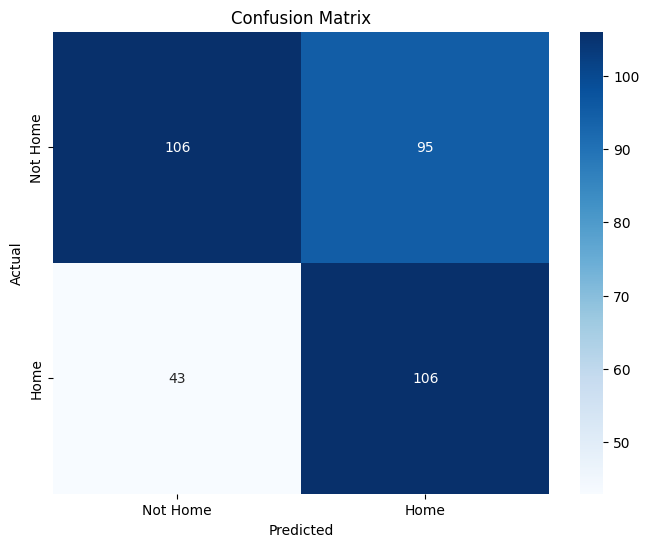

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.0001}
MCC: 0.23877258005275634
accuracy: 0.6057142857142858
              precision    recall  f1-score   support

           0       0.71      0.53      0.61       201
           1       0.53      0.71      0.61       149

    accuracy                           0.61       350
   macro avg       0.62      0.62      0.61       350
weighted avg       0.63      0.61      0.61       350



In [5]:
svm_model = SVC(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight':['balanced'], 
    'tol':[0.0001, 0.01]
}

# Using GridSearchCV to find the best hyperparameters (with weather data)
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search_svm.best_params_

# Building the SVM model with the best parameters
model_svm = SVC(**best_params,probability= True, random_state=42)
model_svm.fit(X_train, y_train)

# Predicting on the test data
y_pred = model_svm.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [6]:
pd.DataFrame(y_pred,columns=['SVM_y_pred']).to_csv('3.SVM_y_pred_with_weather.csv')

In [9]:
y_pred

array([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,

In [8]:
model_svm.predict_proba(X_test)

array([[0.5762769 , 0.4237231 ],
       [0.56185383, 0.43814617],
       [0.59835665, 0.40164335],
       [0.56873582, 0.43126418],
       [0.59747033, 0.40252967],
       [0.59820205, 0.40179795],
       [0.59192727, 0.40807273],
       [0.58238209, 0.41761791],
       [0.59646513, 0.40353487],
       [0.55046528, 0.44953472],
       [0.57039968, 0.42960032],
       [0.58879745, 0.41120255],
       [0.53964184, 0.46035816],
       [0.56402931, 0.43597069],
       [0.58170515, 0.41829485],
       [0.5482659 , 0.4517341 ],
       [0.54263669, 0.45736331],
       [0.57072586, 0.42927414],
       [0.58602402, 0.41397598],
       [0.59313784, 0.40686216],
       [0.56683545, 0.43316455],
       [0.57624468, 0.42375532],
       [0.57517986, 0.42482014],
       [0.59379135, 0.40620865],
       [0.55063955, 0.44936045],
       [0.57347155, 0.42652845],
       [0.59291496, 0.40708504],
       [0.56554341, 0.43445659],
       [0.57328821, 0.42671179],
       [0.57913608, 0.42086392],
       [0.

In [7]:
df_pred_prob = pd.DataFrame(model_svm.predict_proba(X_test)[:,1], columns= ['Y_Pred_Prob_SVM'])
df_pred_prob['Y_Pred_Prob_SVM'] = round(df_pred_prob['Y_Pred_Prob_SVM'],2)
df_pred_prob.to_csv('3.SVM_Y_Pred_Prob.csv', index= False)

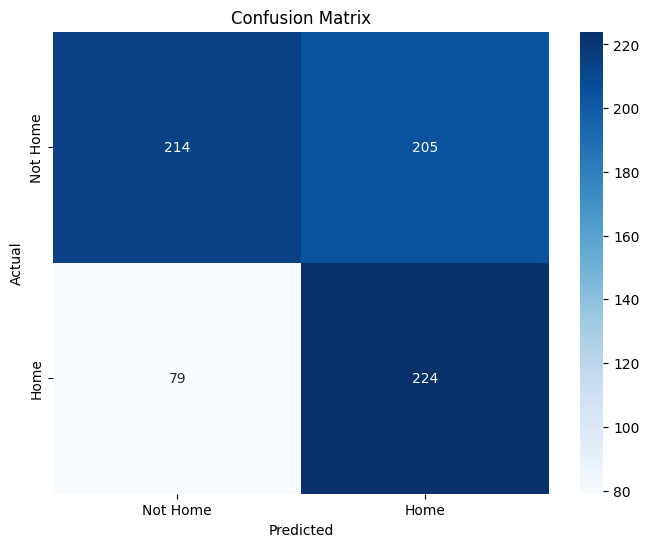

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'tol': 0.0001}
MCC: 0.251263741864096
accuracy: 0.6066481994459834
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       419
           1       0.52      0.74      0.61       303

    accuracy                           0.61       722
   macro avg       0.63      0.63      0.61       722
weighted avg       0.64      0.61      0.61       722



In [53]:
# Predicting on the train data
y_train_pred = model_svm.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
classification_report_output = classification_report(y_train, y_train_pred)

cm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

### Model without Weather Data:

In [5]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 38), (722,), (350, 38), (350,))

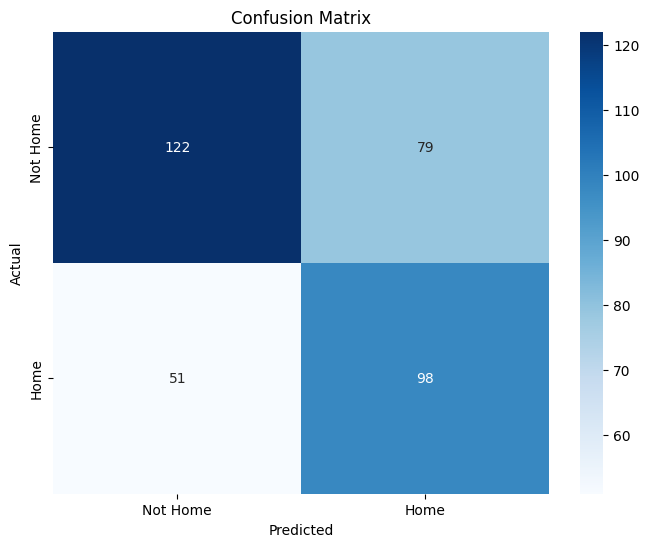

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.0001}
MCC: 0.26176285002353916
accuracy: 0.6285714285714286
              precision    recall  f1-score   support

           0       0.71      0.61      0.65       201
           1       0.55      0.66      0.60       149

    accuracy                           0.63       350
   macro avg       0.63      0.63      0.63       350
weighted avg       0.64      0.63      0.63       350



In [6]:
svm_model = SVC(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight':['balanced'], 
    'tol':[0.0001, 0.01]
}

# Using GridSearchCV to find the best hyperparameters (with weather data)
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search_svm.best_params_

# Building the SVM model with the best parameters
model_svm = SVC(**best_params, random_state=42)
model_svm.fit(X_train, y_train)

# Predicting on the test data
y_pred = model_svm.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [7]:
pd.DataFrame(y_pred,columns=['SVM_y_pred']).to_csv('3.SVM_y_pred_without_weather.csv')

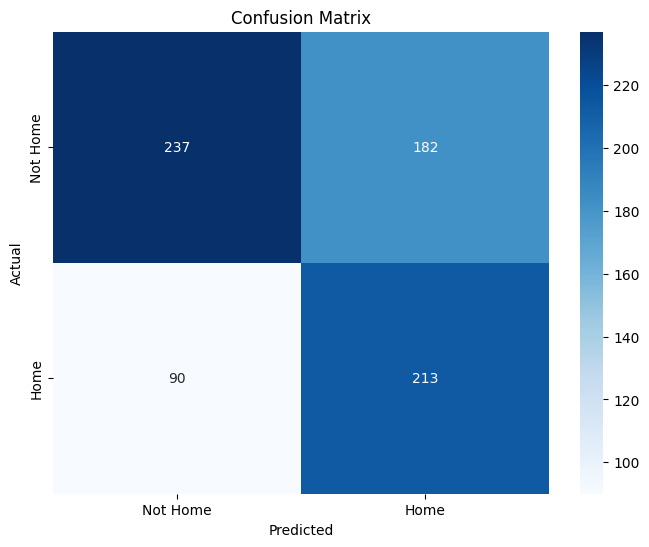

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.0001}
MCC: 0.2662970557774129
accuracy: 0.6232686980609419
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       419
           1       0.54      0.70      0.61       303

    accuracy                           0.62       722
   macro avg       0.63      0.63      0.62       722
weighted avg       0.65      0.62      0.62       722



In [8]:
# Predicting on the train data
y_train_pred = model_svm.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
classification_report_output = classification_report(y_train, y_train_pred)

cm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)